## Training a Custom MobileNet Model

In [1]:
import os

import numpy as np

import keras
from keras.applications import mobilenet_v2, imagenet_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator

import tensorflow

Using TensorFlow backend.


In [2]:
np.random.seed(4096)
tensorflow.set_random_seed(4096)

In [3]:
IMAGE_W = 224
IMAGE_H = 224

INITIAL_LR = 0.0001
EPOCHS = 25
BATCH_SIZE = 32

In [4]:
image_generator = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=mobilenet_v2.preprocess_input,
)

training_generator = image_generator.flow_from_directory(
    'train_images',
    target_size=(IMAGE_W, IMAGE_H),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training'
)

validation_generator = image_generator.flow_from_directory(
    'train_images',
    target_size=(IMAGE_W, IMAGE_H),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='validation'
)

Found 17085 images belonging to 3 classes.
Found 4270 images belonging to 3 classes.


In [5]:
mobilenet_model = mobilenet_v2.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_W,IMAGE_H,3)
)

mobilenet_model.trainable = False

# model = Sequential([
#     mobilenet_model,
#     GlobalAveragePooling2D(),
#     Dense(1024, activation="relu"),
#     Dense(1024, activation="relu"),
#     Dense(512, activation="relu"),
#     Dense(training_generator.num_classes, activation="softmax")
# ])

model = Sequential([
    mobilenet_model,
    Flatten(),
    Dense(1024, activation="relu"),
    Dropout(0.5),
    Dense(training_generator.num_classes, activation="softmax")
])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              64226304  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 66,487,363
Trainable params: 64,229,379
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
model.compile(
    loss="categorical_crossentropy",
    optimizer = RMSprop(lr=INITIAL_LR, decay=INITIAL_LR/EPOCHS),
    metrics=["accuracy"]
)

H = model.fit_generator(
    training_generator,
    validation_data=validation_generator,
    steps_per_epoch=training_generator.samples / training_generator.batch_size,
    validation_steps=validation_generator.samples / validation_generator.batch_size,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0025, verbose=1),
        ModelCheckpoint('mobilenet_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    ]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
534/533 [==============================] - 124s 233ms/step - loss: 0.2535 - acc: 0.9737 - val_loss: 0.9908 - val_acc: 0.9000

Epoch 00001: val_acc improved from -inf to 0.90000, saving model to mobilenet_model.h5
Epoch 2/25
534/533 [==============================] - 121s 227ms/step - loss: 0.0170 - acc: 0.9974 - val_loss: 1.4006 - val_acc: 0.8513

Epoch 00002: val_acc did not improve from 0.90000
Epoch 3/25
534/533 [==============================] - 121s 227ms/step - loss: 0.0098 - acc: 0.9988 - val_loss: 1.5551 - val_acc: 0.8696

Epoch 00003: val_acc did not improve from 0.90000
Epoch 4/25
534/533 [==============================] - 121s 227ms/step - loss: 0.0097 - acc: 0.9985 - val_loss: 1.0476 - val_acc: 0.9171

Epoch 00004: val_acc improved from 0.90000 to 0.91710, saving model to mobilenet_model.h5
Epoch 5/25
534/533 [==============================] - 122s 228ms/step - loss: 0.0041 - acc: 0.9994 - val_loss: 1.6008 - val_acc

## Evaluate Performance

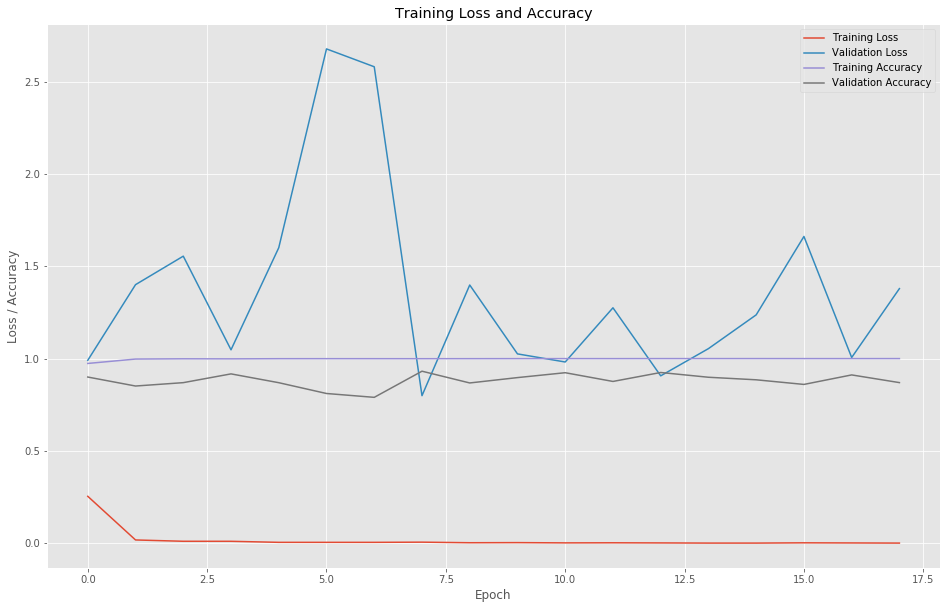

In [10]:
import matplotlib.pyplot as plt
import numpy as np

N = np.arange(0, len(H.history["acc"]))
plt.style.use("ggplot")
plt.figure(figsize=(16,10))
plt.plot(N, H.history["loss"], label="Training Loss")
plt.plot(N, H.history["val_loss"], label="Validation Loss")
plt.plot(N, H.history["acc"], label="Training Accuracy")
plt.plot(N, H.history["val_acc"], label="Validation Accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.show()

In [9]:
model = keras.models.load_model('mobilenet_model.h5')

loss, accuracy = model.evaluate_generator(
    validation_generator,
    steps=validation_generator.samples / validation_generator.batch_size
)

print(f"Loss = {loss:0.5f}, Accuracy = {accuracy*100:0.2f}%")

/home/sam/anaconda3/envs/keras/lib/python3.7/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Loss = 0.82155, Accuracy = 93.04%
